# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'casa-mc-kmeans'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def combined_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    final_cp = False
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)
                
    accelerator.wait_for_everyone()
    if not final_cp:
        aspect_dataset = AspectDetectionDataset(
            X_pool, 
            [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
            label_mapping, 
            tokenizer, 
            max_length=sequence_length
        )
        aspect_loader = DataLoader(
            aspect_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

        start_time = time.time()

        mc_indices = monte_carlo_dropout_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples)
        mc_indices = [remaining_indices[i] for i in mc_indices]
        accelerator.print(f"Got {len(mc_indices)} samples from mc")

        kmeans_indices = kmeans_clustering_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples)
        kmeans_indices = [remaining_indices[i] for i in kmeans_indices]
        accelerator.print(f"Got {len(kmeans_indices)} samples from kmeans")

        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(mc_indices).union(set(kmeans_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'fuel': [y_train[i][0] for i in temp],
                    'machine': [y_train[i][1] for i in temp],
                    'others': [y_train[i][2] for i in temp],
                    'part': [y_train[i][3] for i in temp],
                    'price': [y_train[i][4] for i in temp],
                    'service': [y_train[i][5] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

In [21]:
def monte_carlo_dropout_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples, mc_passes=3):
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    aspect_uncertainties = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
                probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
                batch_probs.append(probs)
                
        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)
        aspect_uncertainties.extend(uncertainties)

        for i in range(len(mean_probs)):
            aspect_outputs[batch['ori_indices'][i].item()] = [np.max(torch.sigmoid(outputs[i]).cpu().numpy())]
            
            for j in range(len(mean_probs[i])):
                if int(mean_probs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    aspect_outputs = {i: aspect_uncertainties[i] for i in range(len(aspect_uncertainties))}
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                preds = torch.sigmoid(outputs.logits)

                for j in range(len(preds)):
                    ori_index = batch['ori_indices'][j].item()
                    if ori_index in sentiment_outputs.keys():
                        sentiment_outputs[ori_index].append(preds[j].cpu().numpy())
                    else:
                        sentiment_outputs[ori_index] = [preds[j].cpu().numpy()]

    for indices, probs in sentiment_outputs.items():
        sentiment_outputs[indices] = [[probs[i], probs[i+1], probs[i+2]] for i in range(int(len(probs) / 3))]
        
        variance = np.var(sentiment_outputs[indices], axis=1)
        mean_aspect_variance = np.mean(variance, axis=1)
        mean_data_variance = np.mean(mean_aspect_variance)
        
        sentiment_outputs[indices] = np.mean(np.mean(np.var(sentiment_outputs[indices], axis=0), axis=0), axis=0)

    aspect_outputs = dict(sorted(aspect_outputs.items()))
    if len(data) > 0:
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = (val + aspect_outputs[key]) / 2

    uncertainties = np.array(list(aspect_outputs.values()))
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    threshold = np.percentile(uncertainties, 90)
    least_confident_indices = sorted_unc[:target_samples]

    return least_confident_indices

In [22]:
def kmeans_clustering_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples, n_clusters=min_increment):
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    aspect_outputs = dict(sorted(aspect_outputs.items()))

    if len(data) > 0:
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

    embeddings = np.array(list(aspect_outputs.values()))

    # Cluster the data based on its embeddings
    kmeans=KMeans(n_clusters=n_clusters, n_init=1)
    kmeans.fit(embeddings)
    
    for cluster_id in range(n_clusters):
        # Cluster center and indices of samples in the current cluster
        cluster_center = kmeans.cluster_centers_[cluster_id]
        cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
    
        if cluster_indices.size == 0:
            # Skip clusters with no members
            print(f"Cluster {cluster_id} has no members, skipping.")
            continue
    
        # Calculate distances of each point in the cluster from the cluster center
        cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
    
        # Determine the local threshold (10th percentile of closest distances to cluster center)
        local_threshold = np.percentile(cluster_distances, 90)
        thresholds.append(local_threshold)
    
        below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
        collected_indices.update(below_threshold_indices)

    # To handle multiple points with same distance
    if len(collected_indices) > target_samples:
        collected_indices = np.array(list(collected_indices))
        np.random.shuffle(collected_indices)
        collected_indices = collected_indices[:target_samples]

    return collected_indices[:target_samples]

# MAIN LOOP

In [23]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size

    aspect_model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1')
    sentiment_model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1')
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [24]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Launching training on 2 GPUs.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7407, Accuracy: 0.6763, F1 Micro: 0.7922, F1 Macro: 0.7203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6343, Accuracy: 0.7879, F1 Micro: 0.8807, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5789, Accuracy: 0.7894, F1 Micro: 0.8819, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5233, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5103, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4753, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 7/10, Train Loss: 0.4497, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4578, Accuracy: 0.7954, F1 Micro: 0.8852, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4419, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6752, Accuracy: 0.6316, F1 Micro: 0.6316, F1 Macro: 0.4904
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6838, Accuracy: 0.7632, F1 Micro: 0.7632, F1 Macro: 0.5824
Epoch 3/10, Train Loss: 0.6594, Accuracy: 0.6842, F1 Micro: 0.6842, F1 Macro: 0.525
Epoch 4/10, Train Loss: 0.6192, Accuracy: 0.5789, F1 Micro: 0.5789, F1 Macro: 0.4882
Epoch 5/10, Train Loss: 0.5884, Accuracy: 0.5526, F1 Micro: 0.5526, F1 Macro: 0.5117
Epoch 6/10, Train Loss: 0.5081, Accuracy: 0.4474, F1 Micro: 0.4474, F1 Macro: 0.4376
Epoch 7/10, Train Loss: 0.5124, Accuracy: 0.4211, F1 Micro: 0.4211, F1 Macro: 0.4146
Epoch 8/10, Train Loss: 0.4269, Accuracy: 0.4474, F1 Micro: 0.4474, F1 Macro: 0.4376
Epoch 9/10, Train Loss: 0.4204, Accuracy: 0.5263, F1 Micro: 0.5263, F1 Macro: 0.5043
Epoch 10/10, Train Loss: 0.3547, Accuracy: 0.5789, F1 Micro: 0.5789, F1 Macro: 0.5323

Sentiment analysis accuracy: 0.7632, F1 Micro: 0.7632, F1 Macro: 0.5824
           

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.667, Accuracy: 0.7857, F1 Micro: 0.8783, F1 Macro: 0.8752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5224, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4847, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4537, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4597, Accuracy: 0.8043, F1 Micro: 0.8889, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.42, Accuracy: 0.8095, F1 Micro: 0.8918, F1 Macro: 0.8905
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4179, Accuracy: 0.8155, F1 Micro: 0.8933, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3618, Accuracy: 0.84, F1 Micro: 0.9059, F1 Macro: 0.904
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.301

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6189, Accuracy: 0.7151, F1 Micro: 0.7151, F1 Macro: 0.4169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5864, Accuracy: 0.7151, F1 Micro: 0.7151, F1 Macro: 0.4169
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5028, Accuracy: 0.8324, F1 Micro: 0.8324, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3981, Accuracy: 0.8771, F1 Micro: 0.8771, F1 Macro: 0.8454
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2494, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2126, Accuracy: 0.9218, F1 Micro: 0.9218, F1 Macro: 0.9062
Epoch 7/10, Train Loss: 0.1188, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.9
Epoch 8/10, Train Loss: 0.1458, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8855
Epoch 9/10, Train Loss: 0.1185, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6321, Accuracy: 0.7902, F1 Micro: 0.8822, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5097, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4916, Accuracy: 0.7991, F1 Micro: 0.8866, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4692, Accuracy: 0.8073, F1 Micro: 0.891, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.424, Accuracy: 0.8125, F1 Micro: 0.8925, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3831, Accuracy: 0.8408, F1 Micro: 0.906, F1 Macro: 0.9036
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3416, Accuracy: 0.8921, F1 Micro: 0.9352, F1 Macro: 0.9339
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2756, Accuracy: 0.9107, F1 Micro: 0.9454, F1 Macro: 0.9435
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6023, Accuracy: 0.6638, F1 Micro: 0.6638, F1 Macro: 0.399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4767, Accuracy: 0.7074, F1 Micro: 0.7074, F1 Macro: 0.5328
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4263, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.284, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9457
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.937
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.919
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9324
Epoch 10/10, Train Loss: 0.0629, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6137, Accuracy: 0.7887, F1 Micro: 0.8818, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5329, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5013, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.446, Accuracy: 0.814, F1 Micro: 0.8922, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3673, Accuracy: 0.8653, F1 Micro: 0.9179, F1 Macro: 0.9141
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3203, Accuracy: 0.9144, F1 Micro: 0.9476, F1 Macro: 0.9457
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2531, Accuracy: 0.9353, F1 Micro: 0.9599, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2071, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5861, Accuracy: 0.6777, F1 Micro: 0.6777, F1 Macro: 0.4039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5521, Accuracy: 0.7521, F1 Micro: 0.7521, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3329, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2323, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9481
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9256, F1 Micro: 0.9256, F1 Macro: 0.9188
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9425
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9354
Epoch 10/10, Train Loss: 0.0858, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6037, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5339, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.486, Accuracy: 0.8021, F1 Micro: 0.8867, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4307, Accuracy: 0.8497, F1 Micro: 0.9108, F1 Macro: 0.9092
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3356, Accuracy: 0.9137, F1 Micro: 0.9464, F1 Macro: 0.9442
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2605, Accuracy: 0.9345, F1 Micro: 0.9593, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2173, Accuracy: 0.9487, F1 Micro: 0.9679, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1673, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5682, Accuracy: 0.6883, F1 Micro: 0.6883, F1 Macro: 0.4529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3474, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2528, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.913
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.93
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.9117
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9278
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9271, F1 Micro: 0.9271, F1 Macro: 0.9197
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9271, F1 Micro: 0.9271, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9365
Epoch 10/10, Train Loss: 0.0438, Accuracy: 0.9271, F1 Micro: 0.9271, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5918, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 2/10, Train Loss: 0.507, Accuracy: 0.7939, F1 Micro: 0.8821, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4589, Accuracy: 0.8274, F1 Micro: 0.8988, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3634, Accuracy: 0.91, F1 Micro: 0.9447, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.276, Accuracy: 0.936, F1 Micro: 0.9601, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2032, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9684
Epoch 7/10, Train Loss: 0.1675, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1402, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1091, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5248, Accuracy: 0.7183, F1 Micro: 0.7183, F1 Macro: 0.5319
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3136, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9359
Epoch 4/10, Train Loss: 0.2251, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8963
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9081
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9375
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.128, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9418
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9332
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9164
Epoch 10/10, Train Loss: 0.0629, Accuracy: 0.9325, F1 Micro: 0.9325, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5916, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5245, Accuracy: 0.8036, F1 Micro: 0.8873, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4713, Accuracy: 0.8304, F1 Micro: 0.9014, F1 Macro: 0.9
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3776, Accuracy: 0.9204, F1 Micro: 0.9507, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2883, Accuracy: 0.9368, F1 Micro: 0.9606, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2106, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9699
Epoch 7/10, Train Loss: 0.1633, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1255, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1097, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5661, Accuracy: 0.6733, F1 Micro: 0.6733, F1 Macro: 0.4024
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3732, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.893
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2162, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8925
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2054, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9213
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9175
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9175
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1432, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9284
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1022, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9335
Epoch 10/10, Train Loss: 0.0607, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5825, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5254, Accuracy: 0.8118, F1 Micro: 0.8933, F1 Macro: 0.8924
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4641, Accuracy: 0.8713, F1 Micro: 0.9236, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3512, Accuracy: 0.9338, F1 Micro: 0.9588, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2491, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1949, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9724
Epoch 7/10, Train Loss: 0.1442, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1253, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1022, Accuracy: 0.9658, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5279, Accuracy: 0.7891, F1 Micro: 0.7891, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2839, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9254
Epoch 3/10, Train Loss: 0.1491, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9171
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9311
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1478, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9349
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9465
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9384
Epoch 10/10, Train Loss: 0.0473, Accuracy: 0.9492, F1 Micro: 0.9492, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5969, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5056, Accuracy: 0.8088, F1 Micro: 0.8919, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4395, Accuracy: 0.9018, F1 Micro: 0.9392, F1 Macro: 0.9359
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.314, Accuracy: 0.936, F1 Micro: 0.9601, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2237, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.164, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1333, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.1057, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5032, Accuracy: 0.8555, F1 Micro: 0.8555, F1 Macro: 0.8173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3071, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9391
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1322, Accuracy: 0.957, F1 Micro: 0.957, F1 Macro: 0.9508
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9306
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.927
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9249
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9304
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9356
Epoch 10/10, Train Loss: 0.0562, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9274

Sentiment analysis accuracy: 0.957, F1 Micro: 0.957, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.583, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.513, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4434, Accuracy: 0.9085, F1 Micro: 0.9433, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3411, Accuracy: 0.9323, F1 Micro: 0.9577, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2465, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1804, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1449, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.108, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9776
Epoch 9/10, Train Loss: 0.0887, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5056, Accuracy: 0.8849, F1 Micro: 0.8849, F1 Macro: 0.8659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2672, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9428
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9267
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0966, Accuracy: 0.9643, F1 Micro: 0.9643, F1 Macro: 0.9595
Epoch 8/10, Train Loss: 0.0991, Accuracy: 0.9603, F1 Micro: 0.9603, F1 Macro: 0.9554
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9392
Epoch 10/10, Train Loss: 0.0483, Accuracy: 0.9405, F1 Micro: 0.9405, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5796, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.499, Accuracy: 0.8103, F1 Micro: 0.8914, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3989, Accuracy: 0.9219, F1 Micro: 0.9517, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2899, Accuracy: 0.9487, F1 Micro: 0.9679, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2078, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1509, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1247, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5071, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8538
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.278, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9275
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9153
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9398
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9316
Epoch 10/10, Train Loss: 0.0663, Accuracy: 0.9261, F1 Micro: 0.9261, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5692, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5063, Accuracy: 0.8185, F1 Micro: 0.8967, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.402, Accuracy: 0.9196, F1 Micro: 0.9502, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2782, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2047, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.974
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9786
Epoch 8/10, Train Loss: 0.0934, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9782
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4699, Accuracy: 0.8854, F1 Micro: 0.8854, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.187, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1669, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1182, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9426
Epoch 5/10, Train Loss: 0.1117, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9303
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.938
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9468
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.939
Epoch 10/10, Train Loss: 0.0556, Accuracy: 0.9486, F1 Micro: 0.9486, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5631, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.497, Accuracy: 0.8147, F1 Micro: 0.8931, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3773, Accuracy: 0.936, F1 Micro: 0.9604, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2539, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1856, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5263, Accuracy: 0.8835, F1 Micro: 0.8835, F1 Macro: 0.861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9375
Epoch 3/10, Train Loss: 0.1443, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9138
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9056
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0714, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9399
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9292
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9321
Epoch 10/10, Train Loss: 0.0529, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9119

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5671, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4995, Accuracy: 0.8237, F1 Micro: 0.8993, F1 Macro: 0.8984
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3712, Accuracy: 0.9263, F1 Micro: 0.9539, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2552, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1712, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.1042, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0714, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4729, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.9042
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1417, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9319
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1076, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9455, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5589, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4679, Accuracy: 0.8519, F1 Micro: 0.9137, F1 Macro: 0.9129
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3381, Accuracy: 0.9286, F1 Micro: 0.9552, F1 Macro: 0.9512
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2255, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4748, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.211, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.127, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9403
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9161
Epoch 6/10, Train Loss: 0.073, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9237
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9201
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9169
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9224
Epoch 10/10, Train Loss: 0.0434, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9116

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5568, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4827, Accuracy: 0.8371, F1 Micro: 0.9056, F1 Macro: 0.9047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3532, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2304, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1668, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9717

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4607, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2925, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8988
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9373
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9249
Epoch 5/10, Train Loss: 0.1127, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9282
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9213
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.917
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9065
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9213
Epoch 10/10, Train Loss: 0.0509, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9329

Sentiment analysis accuracy: 0.9432, F1 Micro: 0.9432, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5608, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4644, Accuracy: 0.8676, F1 Micro: 0.9221, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3163, Accuracy: 0.9442, F1 Micro: 0.9655, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2184, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9803
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4888, Accuracy: 0.8697, F1 Micro: 0.8697, F1 Macro: 0.8605
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1328, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0898, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9382
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9502, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4522, Accuracy: 0.8549, F1 Micro: 0.9135, F1 Macro: 0.9114
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3134, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2168, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9673, F1 Micro: 0.9796, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4798, Accuracy: 0.8792, F1 Micro: 0.8792, F1 Macro: 0.8693
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1388, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9279
Epoch 5/10, Train Loss: 0.1006, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0689, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.936
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9316
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9207
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9434, F1 Micro: 0.9434, F1 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5535, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4673, Accuracy: 0.843, F1 Micro: 0.9087, F1 Macro: 0.9079
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3231, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2189, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1511, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.971, F1 Micro: 0.9819, F1 Macro: 0.9811
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5019, Accuracy: 0.8831, F1 Micro: 0.8831, F1 Macro: 0.8575
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2966, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9637, F1 Micro: 0.9637, F1 Macro: 0.9601
Epoch 4/10, Train Loss: 0.1343, Accuracy: 0.9556, F1 Micro: 0.9556, F1 Macro: 0.9514
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9355, F1 Micro: 0.9355, F1 Macro: 0.9302
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9556, F1 Micro: 0.9556, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9637, F1 Micro: 0.9637, F1 Macro: 0.9601
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9597, F1 Micro: 0.9597, F1 Macro: 0.9555
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9257
Epoch 10/10, Train Loss: 0.0439, Accuracy: 0.9516, F1 Micro: 0.9516, F1 Macro: 0.9463

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5438, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4572, Accuracy: 0.8765, F1 Micro: 0.9266, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3043, Accuracy: 0.9479, F1 Micro: 0.9678, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.979
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.979
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.9801
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.525, Accuracy: 0.8609, F1 Micro: 0.8609, F1 Macro: 0.8542
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2352, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9361
Epoch 4/10, Train Loss: 0.1305, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9511, F1 Micro: 0.9511, F1 Macro: 0.9453
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9372
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9263
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9332
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9204
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9024

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5407, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4396, Accuracy: 0.9077, F1 Micro: 0.9435, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2778, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9787
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.979
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4575, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9329
Epoch 2/10, Train Loss: 0.208, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9454
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9413
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.941
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9329
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9489
Epoch 10/10, Train Loss: 0.0486, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9403

Sentiment analysis accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5497, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4328, Accuracy: 0.8958, F1 Micro: 0.9376, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2848, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1943, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9799
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9695, F1 Micro: 0.9807, F1 Macro: 0.9792
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4633, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2056, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9447
Epoch 3/10, Train Loss: 0.1466, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9444
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9496, F1 Micro: 0.9496, F1 Macro: 0.9444
Epoch 6/10, Train Loss: 0.0808, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9355
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9348
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.94
Epoch 10/10, Train Loss: 0.0639, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.939

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4368, Accuracy: 0.8891, F1 Micro: 0.9332, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2721, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.981
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9805
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9751
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4994, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9052
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9288
Epoch 4/10, Train Loss: 0.1421, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9231
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0748, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9361
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8961
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9213
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0443, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9395

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5438, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4261, Accuracy: 0.8929, F1 Micro: 0.9344, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2713, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9732
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4317, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1986, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1884, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9285
Epoch 4/10, Train Loss: 0.1041, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9356
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9282
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9312
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9244
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9153
Epoch 10/10, Train Loss: 0.0374, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9238

Sentiment analysi

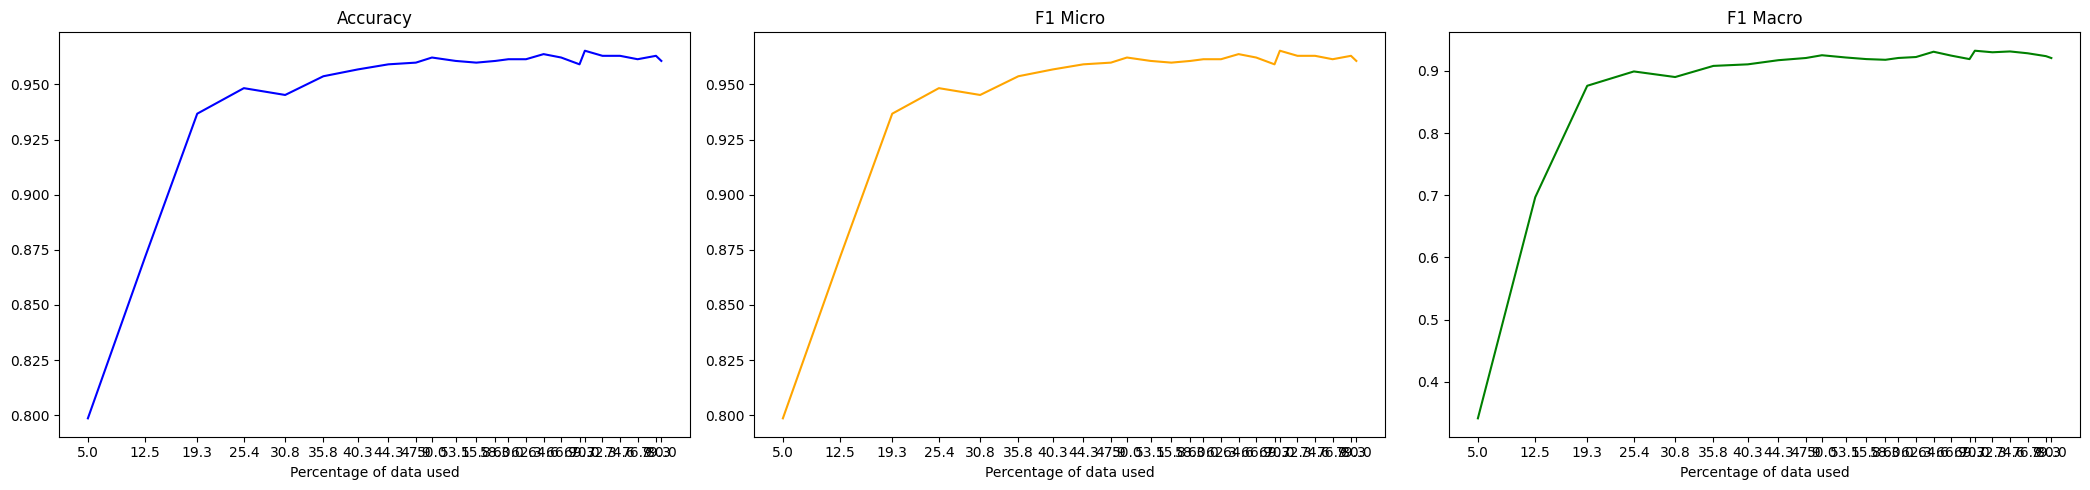

In [25]:
active_learning(seeds[0], 0)